In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45743")
client

<Client: 'tcp://127.0.0.1:45743' processes=8 threads=64, memory=235.96 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [10]:
MLDe = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_fma.zarr")).MLD
MLDf = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FESOM/MLD_fma.zarr")).MLD
MLDg = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_fma.zarr")).MLD
MLDh = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/MLD_fma.zarr")).MLD
MLDo = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLD_fma.zarr")).MLD
MLDl = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/LLC4320/MLD_fma.zarr")).MLD
MLDfi = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/MLD_fma.zarr")).MLD

In [6]:
enatl01w = cat.eNATL60(region='1',datatype='interior_daily', season='fma'
                      ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1)
                                      ).chunk({'deptht':5,'depthw':5,
                                               'depthv':5,'depthu':5})
enatl01w

<xarray.Dataset>
Dimensions:       (deptht: 106, depthu: 106, depthv: 106, depthw: 107, time_counter: 89, x: 611, y: 763)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: x, y
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

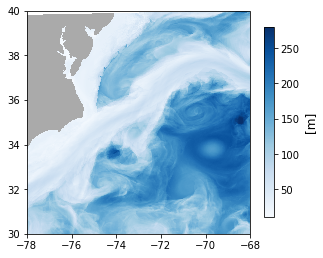

In [7]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolormesh(enatl01w.lon, enatl01w.lat,
              np.abs(MLDe.isel(time_counter=slice(None,15)).mean('time_counter',skipna=True)).data,
              vmin=10., vmax=280, cmap='Blues', rasterized=True
             )

ax.pcolormesh(enatl01w.lon, enatl01w.lat, 
              np.ma.masked_values(enatl01w.tmask.isel(deptht=0), 
                                  1.).astype(np.float64),
              vmin=-1, vmax=2, cmap='binary', rasterized=True
             )
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/eNATL01-MLD_Feb-01-15.pdf')

In [8]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('lat','lat').replace('lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        
    '''    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])
    '''

    return ds

###################################

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
###################################


def dll_dist(dlon, dlat, lon, lat):
    """
    Converts lat/lon differentials into distances in meters
    
    parameters:
        dlon : xarray.DataArray longitude differentials 
        dlat : xarray.DataArray latitude differentials 
        lon : xarray.DataArray longitude values
        lat : xarray.DataArray latitude values
    returns:
        dx : xarray.DataArray distance inferred from dlon 
        dy : xarray.DataArray distance inferred from dlat 
    """
    
    distance_1deg_equator = 111000.0
    dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator 
    dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
    return dx, dy

###################################

def add_vertical_coord(ds):
    
    if ds.VertCoordType=='NEW':
        ds['Vtransform'] = 2
    else:
        ds['Vtransform'] = 1

    #####################
    
    ds['sc_r'] = xr.DataArray(ds.sc_r,  dims=["s_rho"])
    ds['sc_w'] = xr.DataArray(ds.sc_w,  dims=["s_w"])
    ds['Cs_r'] = xr.DataArray(ds.Cs_r,  dims=["s_rho"])
    ds['Cs_w'] = xr.DataArray(ds.Cs_w,  dims=["s_w"])

    #####################
    # Including vertical coordinates

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.sc_r - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.sc_r + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

    ds.coords['z_rho'] = z_rho  * ds.mask_rho

    if ds.Vtransform == 1:
        Zo_w = ds.hc * (ds.sc_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_rho + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_w = (ds.hc * ds.sc_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w

    ds.coords['z_w'] = z_w  * ds.mask_rho
    
    return ds


###################################
    
def _compute_metrics_curvilinear(ds):
    """
    Create a xgcm grid and set it in the dataset as a attribute

    Parameters:
        ds : xarray dataset
    returns:
        ds : xarray dataset with the xgcm  grid
        grid : xgcm grid
    """

    # curvilinear grid
    # Create xgcm grid without any metrics
    coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
            'y':{'center':'eta_rho', 'inner':'eta_v'}, 
            'z':{'center':'s_rho',   'outer':'s_w'}}

    grid = Grid(ds, 
              coords=coords,
              boundary='extend')

    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['lon_u'] = grid.interp(ds.lon_rho,'x')
    ds['lat_u'] = grid.interp(ds.lat_rho,'x')
    ds['lon_v'] = grid.interp(ds.lon_rho,'y')
    ds['lat_v'] = grid.interp(ds.lat_rho,'y')
    ds['lon_psi'] = grid.interp(ds.lon_v,'x')
    ds['lat_psi'] = grid.interp(ds.lat_u,'y')
    _coords = ['lon_u','lat_u','lon_v','lat_v','lon_psi','lat_psi']
    ds = ds.set_coords(_coords)
    
    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['z_u'] = grid.interp(ds.z_rho,'x')
    ds['z_v'] = grid.interp(ds.z_rho,'y')
    _coords = ['z_u','z_v']
    ds = ds.set_coords(_coords)
    

    # add horizontal distance metrics for rho, u, v and psi point
    if 'pm' in ds and 'pn' in ds:
        ds['dx_rho'] = 1/ds['pm']
        ds['dy_rho'] = 1/ds['pn']
    else: # backward compatibility, hack
        dlon = grid.interp(grid.diff(ds.lon_rho,'x'),'x')
        dlat =  grid.interp(grid.diff(ds.lat_rho,'y'),'y')
        ds['dx_rho'], ds['dy_rho'] = dll_dist(dlon, dlat, ds.lon_rho, ds.lat_rho)
    
    dlon = grid.interp(grid.diff(ds.lon_u,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_u,'y'),'y')
    ds['dx_u'], ds['dy_u'] = dll_dist(dlon, dlat, ds.lon_u, ds.lat_u)
    dlon = grid.interp(grid.diff(ds.lon_v,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_v,'y'),'y')
    ds['dx_v'], ds['dy_v'] = dll_dist(dlon, dlat, ds.lon_v, ds.lat_v)
    dlon = grid.interp(grid.diff(ds.lon_psi,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_psi,'y'),'y')
    ds['dx_psi'], ds['dy_psi'] = dll_dist(dlon, dlat, ds.lon_psi, ds.lat_psi)

    
    ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 
    
    # add vertical metrics for u, v, rho and psi points
    ds['dz_rho'] = grid.diff(ds.z_w,'z')
    ds['dz_w']   = grid.diff(ds.z_rho,'z')
    ds['dz_u']   = grid.interp(ds.dz_rho,'x')
    ds['dz_v']   = grid.interp(ds.dz_rho,'y')
    ds['dz_psi'] = grid.interp(ds.dz_v,'x')

    # add areas metrics for rho,u,v and psi points
    ds['rArho'] = ds.dx_psi * ds.dy_psi
    ds['rAu']   = ds.dx_v   * ds.dy_v
    ds['rAv']   = ds.dx_u   * ds.dy_u
    ds['rApsi'] = ds.dx_rho * ds.dy_rho

    metrics = {
           ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
           ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
           ('z',): ['dz_rho', 'dz_u', 'dz_v', 'dz_psi', 'dz_w'], # Z distances
           ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
          }

    ds.attrs['xgcm-Grid'] = Grid(ds, 
              coords=coords,
              metrics = metrics,
              periodic=False,
              boundary='extend')

    return ds


gigatl01w = _compute_metrics_curvilinear(add_vertical_coord(adjust_coords(cat.GIGATL(region='1', 
                                                                                     datatype='int', season='fma').to_dask()
                                                                         ))
                                        ).chunk({'eta_rho':200,'xi_rho':200,'eta_v':200,'xi_u':200})
gigatl01w

<xarray.Dataset>
Dimensions:     (eta_rho: 1541, eta_v: 1540, s_rho: 100, s_w: 101, time: 89, xi_rho: 1576, xi_u: 1575)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_rho       (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_w         (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 200, 200, 101), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_psi     (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_psi     (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_u         (time, eta_rho, xi_u, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_v         (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, s_rho, s_w, time, xi_rho, xi_u
Data variables: (12/36)
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...          ...
    dz_v        (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    dz_psi      (time, eta_v, xi_u, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    rArho       (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAu         (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAv         (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rApsi       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
Attributes: (12/71)
    Akt_bak:         [0.0, 0.0]
    Akt_bak_expl:    background vertical mixing coefficient for tracers
    Akt_bak_units:   meter2 second-1
    Akv_bak:         0.0
    Akv_bak_expl:    background vertical mixing coefficient for momentum
    Akv_bak_units:   meter2 second-1
    ...              ...
    tnu4_expl:       biharmonic mixing coefficient for tracers
    type:            ROMS restart file
    units:           meter4 second-1
    v_sponge:        0.0
    x_sponge:        0.0
    xgcm-Grid:       <xgcm.Grid>\nx Axis (not periodic, boundary='extend'):\n...

In [9]:
mask = ~np.ma.masked_values(gigatl01w.mask_rho.isel(),0).mask
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

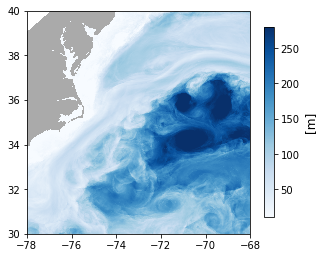

In [10]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolormesh(gigatl01w.lon_rho, gigatl01w.lat_rho,
                   np.abs(MLDg.isel(time=slice(None,15)).mean('time',skipna=True)).data,
                   vmin=10., vmax=280, cmap='Blues', rasterized=True
                  )

ax.pcolormesh(gigatl01w.lon_rho, gigatl01w.lat_rho, 
              np.ma.masked_array(mask, mask),
              vmin=-1, vmax=2, cmap='binary', rasterized=True
             )
ax.set_ylim([30,40])
ax.set_xlim([-78,-68])

cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/GIGA01-MLD_Feb-01-15.pdf')

In [11]:
hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()
hycom50_grid

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503)
Dimensions without coordinates: lat, lon
Data variables:
    depth      (lat, lon) float64 dask.array<chunksize=(615, 503), meta=np.ndarray>
    latitude   (lat) float64 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>

In [12]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='int', season='fma', decode_times=False).to_dask().chunk({'lat':100,'lon':100})
mask = ~np.ma.masked_invalid(hycom01w.s3.isel(time=0,lay=0)).mask
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

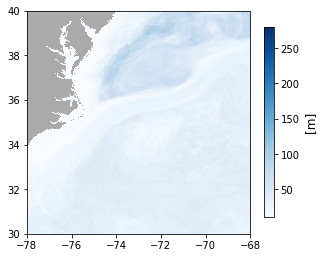

In [13]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolormesh(hycom50_grid.longitude, hycom50_grid.latitude,
                   np.abs(MLDh.isel(time=slice(None,15)).mean('time',skipna=True)).data,
                   vmin=10., vmax=280, cmap='Blues', rasterized=True
                  )

ax.pcolormesh(hycom50_grid.longitude, hycom50_grid.latitude, 
              np.ma.masked_array(mask, mask),
              vmin=-1, vmax=2, cmap='binary', rasterized=True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/HYCOM01-MLD_Feb-01-15.pdf')

In [14]:
fesom01w = cat.FESOM(datatype='int', season='fma').to_dask().chunk({'depth':6})

fesom01w

<xarray.Dataset>
Dimensions:  (depth: 48, lat: 1000, lon: 1000, time: 90)
Coordinates:
  * depth    (depth) float64 0.0 -5.0 -10.0 -15.0 ... -760.0 -860.0 -1.04e+03
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 2012-02-02 ... 2012-04-30
Data variables:
    salt     (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    temp     (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
    w        (time, depth, lat, lon) float32 dask.array<chunksize=(10, 6, 1000, 1000), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Sep 09 15:44:25 2021: cdo mergetime 2012-02_01_w_cubic....

In [15]:
wet_mask = xr.DataArray(np.zeros_like(fesom01w.salt.isel(time=0)),
                        dims=['depth','lat','lon'],
                        coords={'depth':fesom01w.depth,
                                'lat':fesom01w.lat.data,
                                'lon':fesom01w.lon.data}
           )
wet_mask[:,1:-1,1:-1] = (~np.ma.masked_invalid(fesom01w.salt[0,:,1:-1,1:-1].where(fesom01w.salt[0,:,1:-1,1:-1]
                                                                                  >32.).where(fesom01w.salt[0,:,1:-1,1:-1]
                                                                                              <38.).data).mask).astype(np.float64)

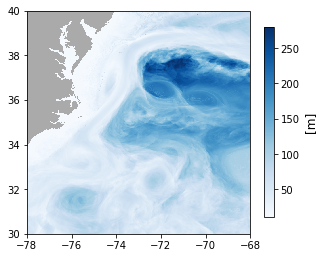

In [16]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolormesh(fesom01w.lon, fesom01w.lat,
              np.abs(MLDf.isel(time=slice(None,15)).mean('time',skipna=True)).data,
              vmin=10., vmax=280, cmap='Blues', rasterized=True
             )
ax.pcolormesh(fesom01w.lon, fesom01w.lat,
              wet_mask.where(wet_mask!=1).isel(depth=0),
              vmin=-1, vmax=2,
              cmap='binary', shading='auto', rasterized=True
             )
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/FESOM01-MLD_Feb-01-15.pdf')

In [17]:
orca01w = cat.ORCA36(region='1',datatype='interior_daily', season='fma'
                    ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1),
                                     y=slice(None,450)
                                    ).chunk({'y':200,'x':200,'deptht':10,'depthw':10,
                                             'depthv':10,'depthu':10})
orca01_grid = cat.ORCA36(region='1',datatype='grid',grid='meshmask'
                        ).to_dask().isel(time_counter=0,nav_lev=slice(None,46),y=slice(None,450))
orca01w

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 46, depthu: 46, depthv: 46, depthw: 47, time_counter: 89, x: 361, y: 450)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthu                (depthu) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthv                (depthv) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthw                (depthw) float32 0.0 1.024 2.103 ... 814.1 901.1 995.7
    nav_lat               (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2014-02-01T12:00:00 ....
    time_instant          (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/22)
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthu_bounds         (depthu, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthv_bounds         (depthv, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthw_bounds         (depthw, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    difvho                (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    e3t                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    ...                    ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    uo                    (time_counter, depthu, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    vo                    (time_counter, depthv, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
    wo                    (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 10, 200, 200), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    NCO:                       "4.6.2"
    description:               ocean T grid variables
    history:                   Wed Jun 23 15:18:24 2021: ncks -O -F -d deptht...
    nco_openmp_thread_number:  1
    title:                     ocean T grid variables
    uuid:                      d5c5d033-89d4-49e9-9626-748d94a29c1f

In [18]:
mask = orca01_grid.tmask.reset_coords(drop=True)
mask = xr.DataArray(~np.ma.masked_values(mask,0).mask, 
                         dims=mask.dims,
                         coords=mask.coords)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


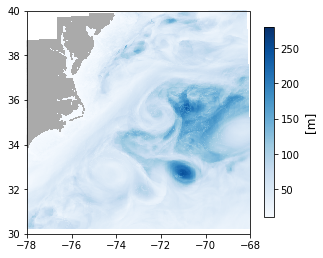

In [19]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolor(orca01w.nav_lon.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=0).data,
                                                  dims=['y','x'])!=0.), 
               orca01w.nav_lat.where(xr.DataArray(orca01_grid.tmask.isel(nav_lev=0).data,
                                                  dims=['y','x'])!=0.),
               np.abs(MLDo.isel(time_counter=slice(None,15)).mean('time_counter',skipna=True)).data,
               vmin=10., vmax=280, cmap='Blues', rasterized=True
             )

ax.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), 
          orca01w.nav_lat.where(orca01w.nav_lat>0.),
          np.ma.masked_array(mask[0], mask[0]),
          vmin=-1, vmax=2, cmap='binary', rasterized=True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/ORCA01-MLD_Feb-01-15.pdf')

In [6]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()

istart = 497664
di = 144
iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)

llc01w = model.get_dataset(varnames=['Theta'], 
#                            k_levels=[0],
                           k_levels=list(range(52)),
#                            iters=list(iters),
                           iters=[istart],
                           type='latlon'
                          ).sel(j=slice(9555,10198),j_g=slice(9555,10198),
                                i=slice(15355,15845),i_g=slice(15355,15845)
                               )

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llc01w, periodic=[],
               coords={
                       'Z':{'center':'k','outer':'k_p1','left':'k_l'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )

In [7]:
mask = ~np.ma.masked_invalid(llc01w.Theta.isel(time=0)).mask

pad = 1
xrmask = xr.DataArray(mask.astype(np.float64), dims=llc01w.Theta.isel(time=0).dims,
                      coords=llc01w.Theta.isel(time=0).coords
                     ).reset_coords(drop=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


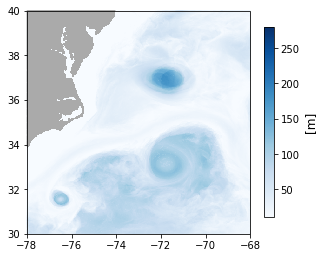

In [9]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolor(llc01w.XC, llc01w.YC,
               np.abs(MLDl.isel(time=slice(None,15)).mean('time',skipna=True)).data,
               vmin=10., vmax=280, cmap='Blues', shading='auto', rasterized=True
             )

ax.pcolor(llc01w.XC, llc01w.YC,
          np.ma.masked_array(xrmask[0], xrmask[0]),
          vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/LLC01-MLD_Feb-01-15.pdf')

In [7]:
fio01w = cat["FIO-COM32"](region='1',datatype='interior_daily', season='fma').to_dask().chunk({'yt_ocean':100,'xt_ocean':100})

mask = ~np.ma.masked_invalid(fio01w.temp.isel(time=0)).mask
wet_mask = xr.DataArray(np.zeros_like(fio01w.temp.isel(time=0)),
                        dims=['st_ocean','yt_ocean','xt_ocean'],
                        coords=fio01w.temp.isel(time=0).coords
           )
wet_mask[:] = mask.astype(np.float64)

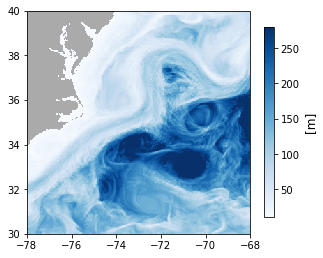

In [13]:
fig = plt.figure(figsize=(5,5))
# fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im = ax.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
                   MLDfi.isel(time=slice(None,15)).mean('time',skipna=True).data,
                   vmin=10., vmax=280, cmap='Blues', rasterized=True
                  )
ax.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
              wet_mask.where(wet_mask!=1).isel(st_ocean=0),
              vmin=-1, vmax=2,
              cmap='binary', shading='auto', rasterized=True
             )
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m]", fontsize=12)
plt.savefig('/home/jovyan/Figures/FIOCOM01-MLD_Feb-01-15.pdf')